# bidirectional

> Implementation of bidirectional associative memories.

Bidirectional Associative Memories are a kind of recurrent neural architecture which allows for *bidirectional* recall of stored associated
memory patterns. In particular, we will be implementing the Nonlinear Dynamic Recurrent Associative Memory for Learning Bipolar and Nonpolar
Correlated Patterns (NDRAM) -- a mouthful -- as well as a Bidirectional Heteroassociative Memory (BHM) based on NDRAM.

In [1]:
# | default_exp bidirectional

In [2]:
# | hide
from nbdev.showdoc import *

In [3]:
# | hide
# | export
import equinox as eqx
import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
from beartype import beartype as typechecker
from beartype import typing as T
from fastcore.basics import *
from fastcore.meta import *
from jaxtyping import Array, Float, jaxtyped
from einops import rearrange

In [4]:
# | hide
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from PIL import Image

In [5]:
# | export
@jaxtyped(typechecker=typechecker)
class NDRAM(eqx.Module):
    """Nonlinear Dynamic Recurrent Associative Memory for Learning Bipolar and Nonpolar Correlated Patterns."""

    W: Float[Array, "D D"]  # The weights of the network
    lr: float  # Learning rate parameter
    tr: float  # Transmission parameter

    @classmethod
    @jaxtyped(typechecker=typechecker)
    def init(
        cls,
        pattern_dim: int,  # The dimension of the patterns the network will be learning and recalling.
        lr: float,  # The learning rate for the weight update step.
        transmission: float,  # Transmission parameter.
    ):
        """Initialize an empty NDRAM network."""
        return cls(
            W=jnp.zeros((pattern_dim, pattern_dim)), lr=lr, transmission=transmission
        )

    @staticmethod
    @jaxtyped(typechecker=typechecker)
    def weight_update(
        weights: Float[Array, "D D"],  # The weights of the network.
        query0: Float[Array, " D"],  # The initial query state time t = 0
        queryt: Float[Array, " D"],  # The current query state at time t
        lr: float,  # The learning rate parameter
    ):
        """Perform a weight update."""
        query0 = rearrange(query0, "d -> d 1")
        queryt = rearrange(queryt, "d -> d 1")
        return weights + (lr * ((query0 @ query0.T) - (queryt @ queryt.T)))

    @staticmethod
    @jaxtyped(typechecker=typechecker)
    def query_update(
        weights: Float[Array, "D D"],  # The weights of the network
        query: Float[Array, " D"],  # The query state
        transmission: float,  # The transmission parameter
        num_transmissions=1,  # Number of transmissions to perform.
    ):
        """Perform a query update."""

        def update_step(query, _i):
            acts = weights @ query

            def f(a_i):
                """Transmission function on activations."""
                gt_1 = a_i > 1.0
                lt_n1 = a_i < -1.0
                return lax.cond(
                    gt_1,
                    lambda: 1.0,
                    lambda: lax.cond(
                        lt_n1,
                        lambda: -1.0,
                        lambda: ((transmission + 1) * a_i) - (transmission * (a_i**3)),
                    ),
                )

            queryt = jax.vmap(f)(acts)
            return queryt, queryt

        iters = np.arange(num_transmissions)
        final_act, _ = lax.scan(update_step, query, iters)
        return final_act

    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def __call__(self, query: Float[Array, " D"]) -> Float[Array, " D"]:
        """Perform one step recall."""
        return NDRAM.query_update(self.W, query, self.tr)

In [6]:
# | export
@jaxtyped(typechecker=typechecker)
def fit_ndram(
    Xi: Float[Array, "N D"],  # The patterns to learn
    lr: float,  # The learning rate parameter
    tr: float,  # The transmission rate parameter
    num_transmissions: int = 1,  # Optional, number of transmission steps to undertake. Default: `1`.
    nsteps: int = 2_000,  # Number of training steps to undertake. Default: `2_000`.
    key: jax.Array = jr.PRNGKey(0),  # Optional, default `jr.PRNGKey(0)`.
):
    """Fit an NDRAM model to the dataset, returning a trained model."""
    are_iters = nsteps is None
    D = Xi.shape[-1]
    init_W = jnp.zeros(shape=(D, D), dtype=jnp.float32)

    def scan_update_step(W, query):
        query_t = NDRAM.query_update(
            W, query, transmission=tr, num_transmissions=num_transmissions
        )
        W_t = NDRAM.weight_update(W, query0=query, queryt=query_t, lr=lr)
        return (W_t, W_t)

    prototypes = jr.choice(key, Xi, shape=(nsteps,))
    final_W, Ws = lax.scan(scan_update_step, init=init_W, xs=prototypes)
    return NDRAM(final_W, lr=lr, tr=tr), None


In [7]:
show_doc(NDRAM.init)

---

### NDRAM.init

>      NDRAM.init (cls, pattern_dim:int, lr:float, transmission:float)

*Initialize an empty NDRAM network.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| cls |  |  |
| pattern_dim | int | The dimension of the patterns the network will be learning and recalling. |
| lr | float | The learning rate for the weight update step. |
| transmission | float | Transmission parameter. |

In [8]:
show_doc(fit_ndram)

---

### fit_ndram

>      fit_ndram (Xi:jaxtyping.Float[Array,'ND'], lr:float, tr:float,
>                 num_transmissions:int=1, nsteps:int=2000,
>                 key:jax.Array=Array([0, 0], dtype=uint32))

*Fit an NDRAM model to the dataset, returning a trained model.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| Xi | Float[Array, 'N D'] |  | The patterns to learn |
| lr | float |  | The learning rate parameter |
| tr | float |  | The transmission rate parameter |
| num_transmissions | int | 1 | Optional, number of transmission steps to undertake. Default: `1`. |
| nsteps | int | 2000 | Number of training steps to undertake. Default: `2_000`. |
| key | Array | [0 0] | Optional, default `jr.PRNGKey(0)`. |

Fit uses the two equations which define the dynamics of NDRAM networks: the weight update rule and the query update rule (1-2) (respectively).
The weight update rule is given by:
$$
W_{(k+1)} = W_{(k)} + \eta \left( x_{(0)} x_{(0)}^T - x_{(t)} x_{(t)}^T \right),
\tag{1}
$$
where $\eta$ is the learning rate parameter, $W_{(k)}$ denotes the weight matrix at time step $k$, $x_{(0)}$ denotes the query buffer at
the initial time step $t = 0$, and $x_{(t)}$ is the current query buffer at time step $t$.

The query update rule is given by:
$$
\begin{align*}
x_i^{(t+1)} &= f(a_i), \\
\text{where}~f(a_i) &= \begin{cases}
    1,&~\text{if}~a_i > 1,\\
    -1,&~\text{if}~a_i < -1, \\
    (\delta + 1)a_i - \delta a_i^3,&~\text{otherwise},
\end{cases}
\end{align*}
\tag{2}
$$
with unfortunately a flipped notation here of $x_i^{(t)}$ denoting the $i$'th element of the query buffer at time $t$, and $\delta$ the *transmission rate*. These are given by
the following methods:

In [9]:
show_doc(NDRAM.weight_update)

---

### NDRAM.weight_update

>      NDRAM.weight_update (weights:jaxtyping.Float[Array,'DD'],
>                           query0:jaxtyping.Float[Array,'D'],
>                           queryt:jaxtyping.Float[Array,'D'], lr:float)

*Perform a weight update.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| weights | Float[Array, 'D D'] | The weights of the network. |
| query0 | Float[Array, 'D'] | The initial query state time t = 0 |
| queryt | Float[Array, 'D'] | The current query state at time t |
| lr | float | The learning rate parameter |

In [10]:
show_doc(NDRAM.query_update)

---

### NDRAM.query_update

>      NDRAM.query_update (weights:jaxtyping.Float[Array,'DD'],
>                          query:jaxtyping.Float[Array,'D'], transmission:float,
>                          num_transmissions=1)

*Perform a query update.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| weights | Float[Array, 'D D'] |  | The weights of the network |
| query | Float[Array, 'D'] |  | The query state |
| transmission | float |  | The transmission parameter |
| num_transmissions | int | 1 | Number of transmissions to perform. |

# Example

In [11]:
DATA_DIR = "../data/mnist"

pxw, pxh = 28, 28


def transform(data):
    data = np.array(data, dtype=jnp.float64)
    data = rearrange(data, "w h -> (w h)")
    data[data > 0.0] = 1.0
    data[data == 0.0] = -1.0
    return data


mnist_train = MNIST(DATA_DIR, train=True, transform=transform)
mnist_data_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
mnist_it = iter(mnist_data_loader)
mnist_data, _ = next(mnist_it)

In [12]:
def mask(
    state: Float[Array, " D"], pct_mask: float = 0.3, key: jax.Array = jr.PRNGKey(11)
) -> Float[Array, " D"]:
    prange = np.array([pct_mask, 1 - pct_mask])
    return state * jr.choice(key, np.array([-1, 1]), p=prange, shape=state.shape)
    # noise = jr.normal(key, shape=(pxh* pxw,))
    # return query * noise


def show_im(im: Float[Array, " WH"], title: str = "") -> None:
    im = im * 255.0
    im = rearrange(im, "(w h) -> w h", w=pxw, h=pxh)
    plt.imshow(im)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])


def show_weights(W, title=""):
    W = jax.block_until_ready(W).__array__()
    plt.imshow(W, cmap="viridis", aspect="auto")
    plt.title(title)
    plt.xticks([])
    plt.yticks([])


Xi = jnp.array(mnist_data[:13])
lr = 0.001
tr = 0.1
ndram, Ws = fit_ndram(Xi, lr, tr)
# show_weights(ndram.W, "Trained Weights")

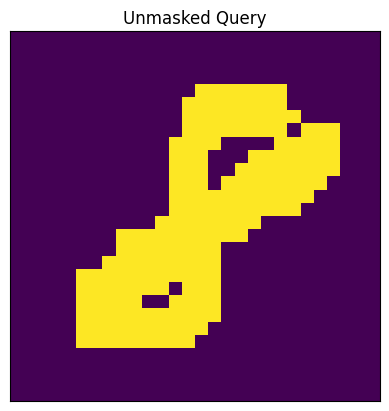

In [13]:
query = Xi[9]
show_im(query, "Unmasked Query")

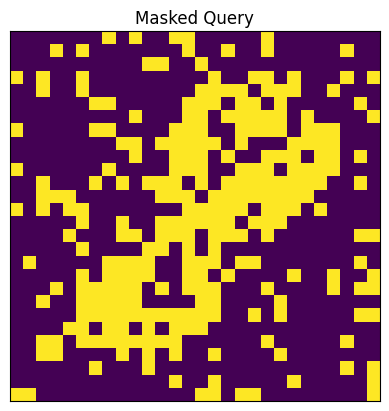

In [14]:
masked_query = mask(query, pct_mask=0.2, key=jr.PRNGKey(11))
show_im(masked_query, "Masked Query")

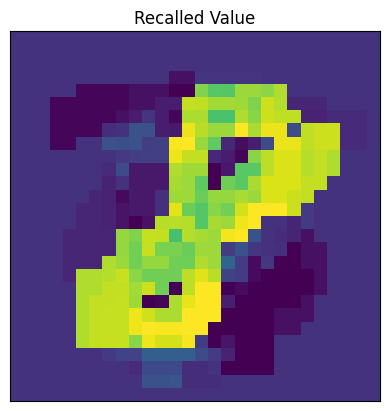

In [15]:
query1 = ndram(masked_query)
show_im(query1, "Recalled Value")

In [16]:
# | hide
import nbdev

nbdev.nbdev_export()